# Step 0: Data Pre-processing

## 0.1: Get Data

In [3]:
import pandas as pd
from pathlib import Path
DATA = Path.home() / "Desktop" / "kraken_data"

columns = [
    "timestamp",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "count"
]

def load_and_cut(file):
    df = pd.read_csv(DATA / file, names=columns)

    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df.set_index("timestamp", inplace=True)

    for c in ["open","high","low","close","volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.loc["2023-03-01":"2023-03-21"]

    return df

df_usd  = load_and_cut("BTCUSD_1m_20230301_20230321.csv")
df_usdc = load_and_cut("BTCUSDC_1m_20230301_20230321.csv")
df_usdt = load_and_cut("BTCUSDT_1m_20230301_20230321.csv")

df_usd.head()

,open,high,low,close,volume,count
timestamp,,,,,,
2023-03-01 00:00:00,23133.2,23146.4,23133.2,23146.0,0.268334,12
2023-03-01 00:01:00,23146.0,23152.3,23144.7,23144.7,0.026393,15
2023-03-01 00:02:00,23144.9,23157.0,23144.9,23157.0,0.255460,14
2023-03-01 00:03:00,23157.3,23158.1,23157.3,23158.1,0.056337,9
2023-03-01 00:04:00,23158.1,23171.6,23158.1,23171.6,1.585688,38


## 0.2: Processing & Cleaning

In [6]:
df = pd.concat(
    [
        df_usdt["close"].rename("usdt"),
        df_usdc["close"].rename("usdc"),
        df_usd["close"].rename("usd"),
    ],
    axis=1
)

df.head()
df.isna().sum()

usdt     9768
usdc    14492
usd        31
dtype: int64

In [7]:
df = df.dropna()
df.isna().sum()
len(df)

11861

<Axes: >

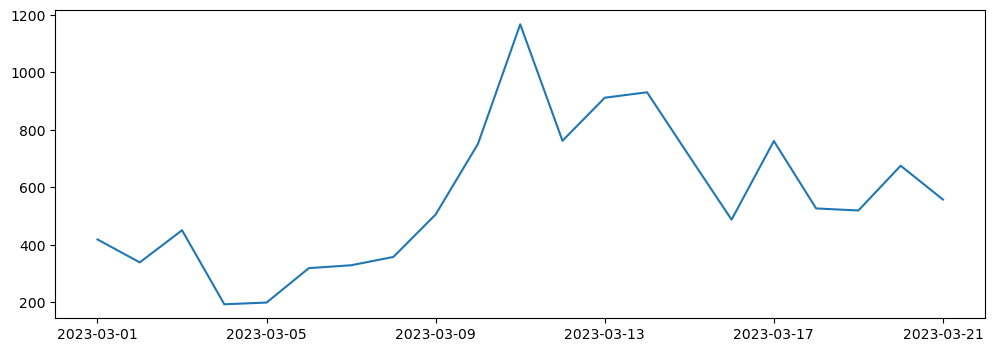

In [8]:
minutes_per_day = df.groupby(df.index.date).size()
minutes_per_day.plot(figsize=(12,4))

# 1 Do stablecoin-quoted markets trade at a premium/discount?

## 1.1 Stablecoin Basis

In [11]:
p_btc_usdt_k = df["usdt"]
p_btc_usdc_k = df["usdc"]
p_btc_usd_k  = df["usd"]

# calculate basis
basis_usdt_k = (p_btc_usdt_k - p_btc_usd_k) / p_btc_usd_k
basis_usdc_k = (p_btc_usdc_k - p_btc_usd_k) / p_btc_usd_k

print('basis_usdt_k:', basis_usdt_k.describe())
print('basis_usdc_k:',basis_usdc_k.describe())
print("Max abs basis USDT:", basis_usdt_k.abs().max())
print("Max abs basis USDC:", basis_usdc_k.abs().max())
print("Correlation (USDT vs USDC basis):", basis_usdt_k.corr(basis_usdc_k))

basis_usdt_k: count    11861.000000
mean        -0.002952
std          0.003070
min         -0.016680
25%         -0.004147
50%         -0.002568
75%         -0.000315
max          0.003257
dtype: float64
basis_usdc_k: count    11861.000000
mean         0.009564
std          0.024191
min         -0.003430
25%         -0.000051
50%          0.000454
75%          0.002076
max          0.140275
dtype: float64
Max abs basis USDT: 0.01667970996728188
Max abs basis USDC: 0.1402747542958126
Correlation (USDT vs USDC basis): -0.5073397837278986


- The stablecoin basis is constructed as the relative price deviation of BTC quoted in USDT or USDC versus BTC/USD, serving as the core metric for premium/discount analysis.
- USDT basis mean ≈ −0.30% → BTC/USDT trades at a slight discount vs BTC/USD  
- USDC basis mean ≈ +0.96% → BTC/USDC trades at a premium on average  
- Max deviation: USDC ≈ 14% vs USDT ≈ 1.7% → larger temporary dislocations in USDC  
- Correlation ≈ −0.51 → USDT and USDC deviations often move in opposite directions  

## 1.2 Cross-Stablecoin Spread

In [12]:
spread_k = basis_usdt_k - basis_usdc_k

print(spread_k.describe())
print("Mean spread:", spread_k.mean())
print("Max abs spread:", spread_k.abs().max())
print("Std spread:", spread_k.std())

count    11861.000000
mean        -0.012517
std          0.025884
min         -0.145664
25%         -0.005808
50%         -0.003034
75%         -0.000357
max          0.003600
dtype: float64
Mean spread: -0.012516605367874118
Max abs spread: 0.1456638201081426
Std spread: 0.02588374633528008


- Mean spread ≈ −1.25% → USDT trades weaker than USDC on average  
- Min spread ≈ −14.6% → periods of strong USDT discount vs USDC  
- Std ≈ 2.6% → relative pricing between USDT and USDC is time-varying  
- Reflects shifts in relative liquidity and market confidence between the two stablecoins

## 1.3 Absolute Deviation Magnitude

In [18]:
abs_usdt_k = basis_usdt_k.abs()
abs_usdc_k = basis_usdc_k.abs()

print("USDT abs basis:")
print(abs_usdt_k.describe())

print("\nUSDC abs basis:")
print(abs_usdc_k.describe())

print("\nMean abs:")
print("USDT:", abs_usdt_k.mean())
print("USDC:", abs_usdc_k.mean())

print("\n95th percentile:")
print("USDT:", abs_usdt_k.quantile(0.95))
print("USDC:", abs_usdc_k.quantile(0.95))

print("\n99th percentile:")
print("USDT:", abs_usdt_k.quantile(0.99))
print("USDC:", abs_usdc_k.quantile(0.99))

USDT abs basis:
count    11861.000000
mean         0.003048
std          0.002975
min          0.000000
25%          0.000497
50%          0.002570
75%          0.004147
max          0.016680
dtype: float64

USDC abs basis:
count    11861.000000
mean         0.009808
std          0.024093
min          0.000000
25%          0.000232
50%          0.000667
75%          0.002109
max          0.140275
dtype: float64

Mean abs:
USDT: 0.0030482336435314044
USDC: 0.009807557611030582

95th percentile:
USDT: 0.009636720352259194
USDC: 0.07677165354330709

99th percentile:
USDT: 0.012850311896899102
USDC: 0.1082445860607555


- **Average deviation**: USDC shows a larger mean absolute basis (~0.0098) than USDT (~0.0030). BTC quoted in USDC deviates from BTC/USD more frequently and by larger amounts
- **Tail risk / stress sensitivity**
  - 95th percentile: USDT ≈ 0.0096 v.s. USDC ≈ 0.0768  
  - 99th percentile: USDT ≈ 0.0129 v.s. USDC ≈ 0.1082.
  - Extreme deviations are substantially larger for USDC.
- **Max deviation**: USDT max ≈ 1.7% v.s. USDC max ≈ 14%. Occasional large dislocations occur in USDC-quoted markets.
- **Stability comparison**: USDT deviations are smaller and more tightly distributed. USDC deviations are more volatile with a heavier right tail.
- Over this sample, USDT markets appear more tightly anchored to USD pricing, while USDC markets exhibit larger and more episodic deviations, indicating stronger short-term dislocation dynamics.

# 2 Dynamic Measures：Do deviations persist? Who reacts faster

## 2.1 Volatility of Basis

In [14]:
window = 60

vol_usdt_k = basis_usdt_k.rolling(window).std()
vol_usdc_k = basis_usdc_k.rolling(window).std()

print("USDT volatility mean:", vol_usdt_k.mean())
print("USDC volatility mean:", vol_usdc_k.mean())
print("USDT volatility max:", vol_usdt_k.max())
print("USDC volatility max:", vol_usdc_k.max())

USDT volatility mean: 0.0006121247423599921
USDC volatility mean: 0.0015606259699590458
USDT volatility max: 0.002074415292592177
USDC volatility max: 0.02752851926373104


- USDC basis volatility is significantly higher than USDT on Kraken. This suggests larger short-term fluctuations in BTC/USDC relative to BTC/USD.
- USDT appears more stable and tightly anchored to USD during this period. The much larger max volatility for USDC indicates occasional stress spikes.
- Overall, deviations in USDC markets are more unstable and episodic.

## 2.2 Mean Reversion Speed

In [19]:
import numpy as np
import statsmodels.api as sm

def half_life(series):
    series = series.dropna()

    lag = series.shift(1)
    delta = series - lag

    df = np.vstack([lag[1:], delta[1:]]).T
    lag2 = df[:,0]
    delta2 = df[:,1]

    X = sm.add_constant(lag2)
    model = sm.OLS(delta2, X).fit()

    beta = model.params[1]

    hl = -np.log(2) / beta
    return hl

hl_usdt_k = half_life(basis_usdt_k)
hl_usdc_k = half_life(basis_usdc_k)

print("Half-life USDT:", hl_usdt_k)
print("Half-life USDC:", hl_usdc_k)

Half-life USDT: 24.979993003708312
Half-life USDC: 285.4161643036949


- Estimated half-life shows a large difference between the two stablecoins  
  - USDT half-life ≈ **25**  
  - USDC half-life ≈ **285**

- This implies deviations in USDT markets revert much faster, while USDC deviations remain in the system for significantly longer.
- A shorter half-life indicates stronger arbitrage activity and deeper trading liquidity.  
  USDT is the primary trading and settlement currency in crypto markets, so pricing dislocations are quickly corrected by arbitrageurs.
- The longer half-life for USDC suggests weaker immediate arbitrage pressure and lower trading depth on the observed platform.  
  Deviations in USDC pricing are therefore more persistent and reflect slower capital movement or settlement frictions.
- From a market structure perspective:  
  - **USDT** behaves as the dominant liquidity anchor  
  - **USDC** behaves as a secondary stablecoin with stickier deviations  

- Overall, the results indicate asymmetric adjustment dynamics:  
  pricing inefficiencies in USDT are rapidly corrected, whereas USDC dislocations persist longer and may capture liquidity or confidence shocks more clearly.

## 2.3 Time Above Threshold

In [21]:
threshold = 0.002

def time_above_threshold(series, th=0.002):
    s = series.dropna()
    flag = (s.abs() > th)

    # fraction of time above threshold
    frac_time = flag.mean()

    # duration of consecutive excursions
    groups = (flag != flag.shift()).cumsum()
    durations = flag.groupby(groups).sum()
    durations = durations[durations > 0]

    avg_duration = durations.mean() if len(durations) > 0 else 0
    max_duration = durations.max() if len(durations) > 0 else 0

    return frac_time, avg_duration, max_duration


usdt_frac_k, usdt_avg_dur_k, usdt_max_dur_k = time_above_threshold(basis_usdt_k, threshold)
usdc_frac_k, usdc_avg_dur_k, usdc_max_dur_k = time_above_threshold(basis_usdc_k, threshold)

print("USDT_k:")
print("  fraction above:", usdt_frac_k)
print("  avg duration:", usdt_avg_dur_k)
print("  max duration:", usdt_max_dur_k)

print("\nUSDC_k:")
print("  fraction above:", usdc_frac_k)
print("  avg duration:", usdc_avg_dur_k)
print("  max duration:", usdc_max_dur_k)

USDT_k:
  fraction above: 0.5875558553241716
  avg duration: 14.922912205567451
  max duration: 1780

USDC_k:
  fraction above: 0.2590000843099233
  avg duration: 8.062992125984252
  max duration: 2383


- USDT spends much more time in stress: ~59% of observations exceed the threshold vs ~26% for USDC → deviations occur more frequently in USDT-quoted markets.
- USDT deviations are more persistent on average: Average excursion duration ≈ 14.9 vs 8.1 → once USDT deviates, it tends to stay off-peg longer.
- But USDC has rarer, more extreme episodes: Max duration for USDC is larger → when stress hits USDC, it can last longer even if it happens less often.
- Overall dynamic:
USDT = frequent, sticky small dislocations
USDC = infrequent but occasionally large stress regimes

# 3 Stress & Regime-Based Measures

## 3.1 Stress-Day Conditional Statistics

In [23]:
ret_btc_k = p_btc_usd_k.pct_change()
vol_btc_k = ret_btc_k.rolling(60).std()

stress_k = (vol_btc_k > vol_btc_k.quantile(0.9)) | (ret_btc_k < ret_btc_k.quantile(0.05))
calm_k = ~stress_k

def cond_stats_k(series_k, mask_k):
    s_k = series_k[mask_k]
    return {
        "mean": round(s_k.mean(), 5),
        "std": round(s_k.std(), 5),
        "max_abs": round(s_k.abs().max(), 5)
    }

print("USDT_k calm:", cond_stats_k(basis_usdt_k, calm_k))
print("USDT_k stress:", cond_stats_k(basis_usdt_k, stress_k))

print("\nUSDC_k calm:", cond_stats_k(basis_usdc_k, calm_k))
print("USDC_k stress:", cond_stats_k(basis_usdc_k, stress_k))

USDT_k calm: {'mean': -0.0029, 'std': 0.00312, 'max_abs': 0.01668}
USDT_k stress: {'mean': -0.0033, 'std': 0.00275, 'max_abs': 0.01611}

USDC_k calm: {'mean': 0.01066, 'std': 0.02554, 'max_abs': 0.14027}
USDC_k stress: {'mean': 0.00265, 'std': 0.01038, 'max_abs': 0.13592}


- **USDT**
  - During stress periods, the mean basis becomes more negative (-0.0033 vs -0.0029), indicating a deeper discount relative to USD.  
  - Volatility slightly decreases (0.00312 → 0.00275), suggesting deviations are more directional rather than noisy.  
  - Extreme deviations remain similar, implying stress shows up as persistent discount rather than short spikes.

- **USDC**
  - In calm periods, the average basis is positive (+0.01066), indicating a persistent premium that compresses during stress (+0.00265).  
  - Volatility drops sharply (0.02554 → 0.01038), showing convergence toward the USD peg under stress.  
  - Large deviations still occur but are concentrated outside stress periods.

- **Interpretation**
  - Under market stress:
    - USDT tends to trade at a sustained discount.  
    - USDC premiums compress toward parity with USD.  
  - This suggests that on Kraken, stress conditions lead to relative weakening in USDT while USDC behaves more like a stability anchor.  

## 3.2 Asymmetry: discount vs premium

In [24]:
def asymmetry_stats_k(series_k):
    neg_k = series_k[series_k < 0]   # discount
    pos_k = series_k[series_k > 0]   # premium
    
    return {
        "discount_mean": round(neg_k.mean(), 5),
        "discount_std": round(neg_k.std(), 5),
        "discount_freq": round(len(neg_k) / len(series_k), 4),

        "premium_mean": round(pos_k.mean(), 5),
        "premium_std": round(pos_k.std(), 5),
        "premium_freq": round(len(pos_k) / len(series_k), 4),
    }

print("USDT_k asymmetry:", asymmetry_stats_k(basis_usdt_k))
print("USDC_k asymmetry:", asymmetry_stats_k(basis_usdc_k))

USDT_k asymmetry: {'discount_mean': -0.00352, 'discount_std': 0.00298, 'discount_freq': 0.8516, 'premium_mean': 0.00033, 'premium_std': 0.00032, 'premium_freq': 0.1465}
USDC_k asymmetry: {'discount_mean': -0.00044, 'discount_std': 0.00043, 'discount_freq': 0.2788, 'premium_mean': 0.01345, 'premium_std': 0.02754, 'premium_freq': 0.7203}


- **USDT**
  - ~85% of observations are **discounts** (below USD parity). Discounts are persistent but small in magnitude. Premiums are rare and tiny.
  - → USDT on Kraken tends to trade **consistently weaker than USD**.

- **USDC**
  - ~72% of observations are **premiums**. Premium episodes are fewer but **much larger in magnitude**. Discounts are infrequent and small.
  - → USDC often trades **above USD** and shows occasional large upward deviations.

- **Relative interpretation**
  - USDT behaves like a **structural discount asset**. USDC behaves like a **premium / flight-to-quality asset**.
  - During stress or liquidity imbalance:
    - capital likely rotates **from USDT → USDC**
    - USDC acts more like a **confidence anchor** on Kraken.